In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import copy
from collections import Counter

In [ ]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
def create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size):
    """
    Generate specific patterns for 5 modes.
    """
    pats = []
    temp_pats = create_specific_patterns4(mode1, mode2, mode3, mode4, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode5] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
def create_specific_patterns8(mode1, mode2, mode3, mode4, mode5, mode6, mode7, mode8, size):
    """
    Generate specific patterns for 8 modes.
    """
    pats = []
    temp_pats = create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode6] = bin_to_pattern(str(k))[0]
            for l in range(2):
                p_prime2 = copy.deepcopy(p_prime)
                p_prime2[mode7] = bin_to_pattern(str(l))[0]
                for m in range(2):
                    p_prime3 = copy.deepcopy(p_prime2)
                    p_prime3[mode8] = bin_to_pattern(str(m))[0]
                    pats.append(p_prime3)
    return pats
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

<h2>Game modeling</h2>

In [3]:
def stringify(seq):
    string = ''
    for n in seq:
        string+=str(n)
    return string

In [4]:
n = 12
sequence_list = np.array([np.array(list(bin(i)[3:]),dtype=np.int32) for i in range(2**n, 2**(n+1))])
len(sequence_list)

4096

In [17]:
def generate_rules_and_rewards(num_rules=5, rule_length=4, reward_range=(1, 20), sequence_length=12):
    """
    Generate rules, rewards, and starting positions for the rules.
    """
    rules = set()
    rewards = []
    starting_positions = []

    while len(rules) < num_rules:
        rule = tuple(np.random.randint(0, 2, size=rule_length))  # Generate a random rule
        if rule not in rules:
            rules.add(rule)
            reward = np.random.randint(reward_range[0], reward_range[1])  # Generate a random reward
            rewards.append(reward)
            # Generate one or more starting positions for the rule
            positions = np.random.choice(range(sequence_length - rule_length + 1), size=np.random.randint(1, 12-rule_length), replace=False)
            starting_positions.append(list(positions))

    return list(rules), rewards, starting_positions


def estimate_cost(sequence, rules, rewards, starting_positions):
    """
    Estimate the cost of a sequence based on the rules, rewards, and starting positions.
    """
    reward = 0
    rule_length = len(rules[0])

    for rule, rule_reward, positions in zip(rules, rewards, starting_positions):
        for k in positions:  # Only check the specified starting positions
            if k + rule_length <= len(sequence) and np.all(sequence[k:k + rule_length] == rule):
                reward += rule_reward
                break  # Stop checking further positions for this rule if it matches

    return np.abs(reward)

<h2>Tests</h2>

In [6]:
def monte_carlo_compressive_learning(Phi,sequence_cost,sample_size=200,threshold=20):

    #Sample
    sample_index = np.random.randint(0,len(sequence_list),sample_size)
    sequence_cost_spectrum = np.zeros_like(sequence_cost)
    sequence_cost_spectrum[sample_index] = sequence_cost[sample_index]

    #Threshold
    sequence_cost_spectrum[sequence_cost_spectrum<threshold]=0

    #Measurements
    y = []
    y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]
    y = np.array(y)

    #Matching pursuit
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
    omp.fit(Phi, y)
    coefficients = [ i if i>0 else 0 for i in omp.coef_]

    return coefficients

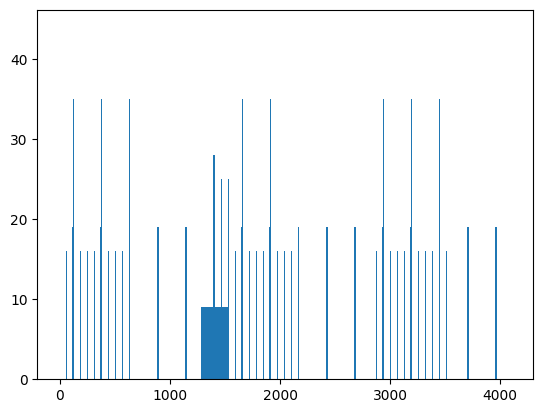

1400
44


In [540]:
nb_rules = 3
rules1, rewards1,pos1 = generate_rules_and_rewards(num_rules=nb_rules,rule_length=4)
# rules2, rewards2,pos2 = generate_rules_and_rewards(num_rules=3,rule_length=2)
# rules3, rewards3,pos3 = generate_rules_and_rewards(num_rules=2,rule_length=3)
# rules4, rewards4,pos4 = generate_rules_and_rewards(num_rules=2,rule_length=6)
# pos1 = [[0,2,4,6,8]]*nb_rules
# pos1 = [np.arange(0,4)]*nb_rules
pos1 = [ [i] for i in np.random.randint(0,8,nb_rules)]

sequence_cost = []
for sequence in sequence_list:
    rew = 0
    rew += estimate_cost(sequence,rules1, rewards1,pos1)
    # rew += estimate_cost(sequence,rules2, rewards2, pos2)
    # rew += estimate_cost(sequence,rules3, rewards3, pos3)
    # rew += estimate_cost(sequence,rules4, rewards4, pos4)
    sequence_cost.append(rew)
sequence_cost = np.array(sequence_cost)

# noise_rate = 0.5
# noise_intensity = 10
# mask = np.random.rand(len(sequence_cost)) <= noise_rate
# noisy_sequence_cost = sequence_cost.copy()
# noisy_sequence_cost[mask]+= np.random.normal(0,noise_intensity,len(sequence_cost)).astype(int)[mask]
# noisy_sequence_cost=np.abs(noisy_sequence_cost)

plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=1.5)
plt.show()
# plt.bar([i for i in np.arange(len(sequence_list))],noisy_sequence_cost,width=0.5)
# plt.show()
ma = np.argmax(sequence_cost)
print(ma)
# print(sequence_list[ma])
print(sequence_cost[ma])

In [541]:
from scipy.optimize import dual_annealing

# Define the objective function
def my_f(x):
    """
    Objective function to minimize.
    Converts x to an integer index and returns the negative sequence cost.
    """
    x = int(round(x[0]))  # Ensure x is a single integer index
    if 0 <= x < len(sequence_cost):  # Check bounds
        return -sequence_cost[x]
    else:
        return float('inf')  # Return a large value if out of bounds

# Define bounds for the single-dimensional problem
bounds = [(0, len(sequence_cost) - 1)]  # Single-dimensional bounds

# Perform dual annealing optimization
results = []
for _ in range(200):
    res = dual_annealing(my_f, bounds=bounds, maxiter=200,no_local_search=True)
    # print("Optimization result:", res)
    results.append(int(round(res.x[0])) in np.argpartition(sequence_cost, -20)[-20:])
np.average(results)

0.47

In [542]:
#Random
Phi = np.random.rand(250,4096)
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(300):
    coefficients = monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh)
    good_opt = np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])
    res.append(1 if len(good_opt) > 0 else 0)
np.average(res)

0.6

In [543]:
#Nearest neighbor quadruplets
all_pat = []
for i in range(n-3):
    all_pat += create_specific_patterns4(i,i+1,i+2,i+3,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(600):
    coefficients = monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh)
    good_opt = np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])
    res.append(1 if len(good_opt) > 0 else 0)
np.average(res)

0.59

In [544]:
#Nearest neighbor quintuplets
all_pat = []
for i in range(n-4):
    all_pat += create_specific_patterns5(i,i+1,i+2,i+3,i+4,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(300):
    coefficients = monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh)
    good_opt = np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])
    res.append(1 if len(good_opt) > 0 else 0)
np.average(res)

0.5466666666666666

In [499]:
#Nearest neighbor pairs
all_pat = []
for i in range(n-1):
    all_pat += create_specific_patterns(i,i+1,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(300):
    coefficients = monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh)
    good_opt = np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])
    res.append(1 if len(good_opt) > 0 else 0)
np.average(res)

c:\Users\Baptiste\Documents\PhD\Projects\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\Baptiste\Documents\PhD\Projects\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\Baptiste\Documents\PhD\Projects\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\Baptiste\Documents\PhD\Projects\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to l

0.12333333333333334

In [500]:
#All pairs
all_pat = []
all_pat = []
for i in range(n):
    for j in range(i+1,n):
        all_pat += create_specific_patterns(i,j,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(300):
    coefficients = monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh)
    good_opt = np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])
    res.append(1 if len(good_opt) > 0 else 0)
np.average(res)

0.33666666666666667

In [501]:
#Nearest neighbor triplets
all_pat = []
for i in range(n-2):
    all_pat += create_specific_patterns3(i,i+1,i+2,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(300):
    coefficients = monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh)
    good_opt = np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])
    res.append(1 if len(good_opt) > 0 else 0)
np.average(res)

c:\Users\Baptiste\Documents\PhD\Projects\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


0.21

In [379]:
#All quadruplets
all_pat = []
for i in range(n):
    for j in range(i+1,n):
        for k in range(j+1,n):
            for l in range(k+1,n):
                all_pat += create_specific_patterns4(i,j,k,l,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(20):
    coefficients = monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh)
    good_opt = np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])
    res.append(1 if len(good_opt) > 0 else 0)
np.average(res)

0.2

In [ ]:
#Nearest neighbor octuplets
all_pat = []
for i in range(n-7):
    all_pat += create_specific_patterns8(i,i+1,i+2,i+3,i+4,i+5,i+6,i+7,n)
Phi = np.array([dev_pattern(p) for p in all_pat])

res = []
for _ in range(100):
    coefficients = monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh)
    good_opt = np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])
    res.append(1 if len(good_opt) > 0 else 0)
np.average(res)

0.93